In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [14]:
from masa_utils import PsuedoLog
from masa_utils import Debye_sum_res_f_re
from masa_utils import Pelton_res_f as Pelton_res_f_np
from masa_utils import InducedPolarizationSimulation as IP_sim_np
from masa_utils import Optimization 
from masa_utils import debye_res_t
from masa_utils_pytorch import Pelton_res_f 
from masa_utils_pytorch import Pelton_con_f
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Optimization

# SIP-Jacobian for Pelton Model 

In [11]:
res0= 0.2
con8 = 10.0
eta= 0.5
tau= 0.01 #0.001
expc= 0.6
parm_true = torch.tensor([np.log(res0), eta, np.log(tau), expc], dtype=torch.float32, requires_grad=False)
model_obs = np.r_[np.log(res0), eta, np.log(tau), expc]

In [ ]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)
freq_plot = freq
# print(freq.shape)
# print(freq)

(71,)
[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.

In [12]:
# simulate for Pytroch
IP_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dpred_torch = sim.dpred(parm_true)
J_torch = sim.J(parm_true)

In [ ]:
dpred_torch_real = dpred_torch[:nfreq].detach().numpy()
dpred_torch_imag = dpred_torch[nfreq:].detach().numpy()

J_torch_real = J_torch[:nfreq, :].detach().numpy()
J_torch_imag = J_torch[nfreq:, :].detach().numpy()

In [ ]:
# simulate for numpy which has analytic derivative
IP_model_np = Pelton_res_f_np(freq=freq)
sim_np = IP_sim_np(ip_model=IP_model_np)
dpred_np = sim_np.dpred(model_obs)
J_np = sim_np.J(model_obs)

In [18]:
dpred_np_real = dpred_np[:nfreq]
dpred_np_imag = dpred_np[nfreq:]
J_np_real = J_np[:nfreq, :]
J_np_imag = J_np[nfreq:, :]

In [16]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq_plot[freq_plot>eps].min())),
            linScalex=0.2)

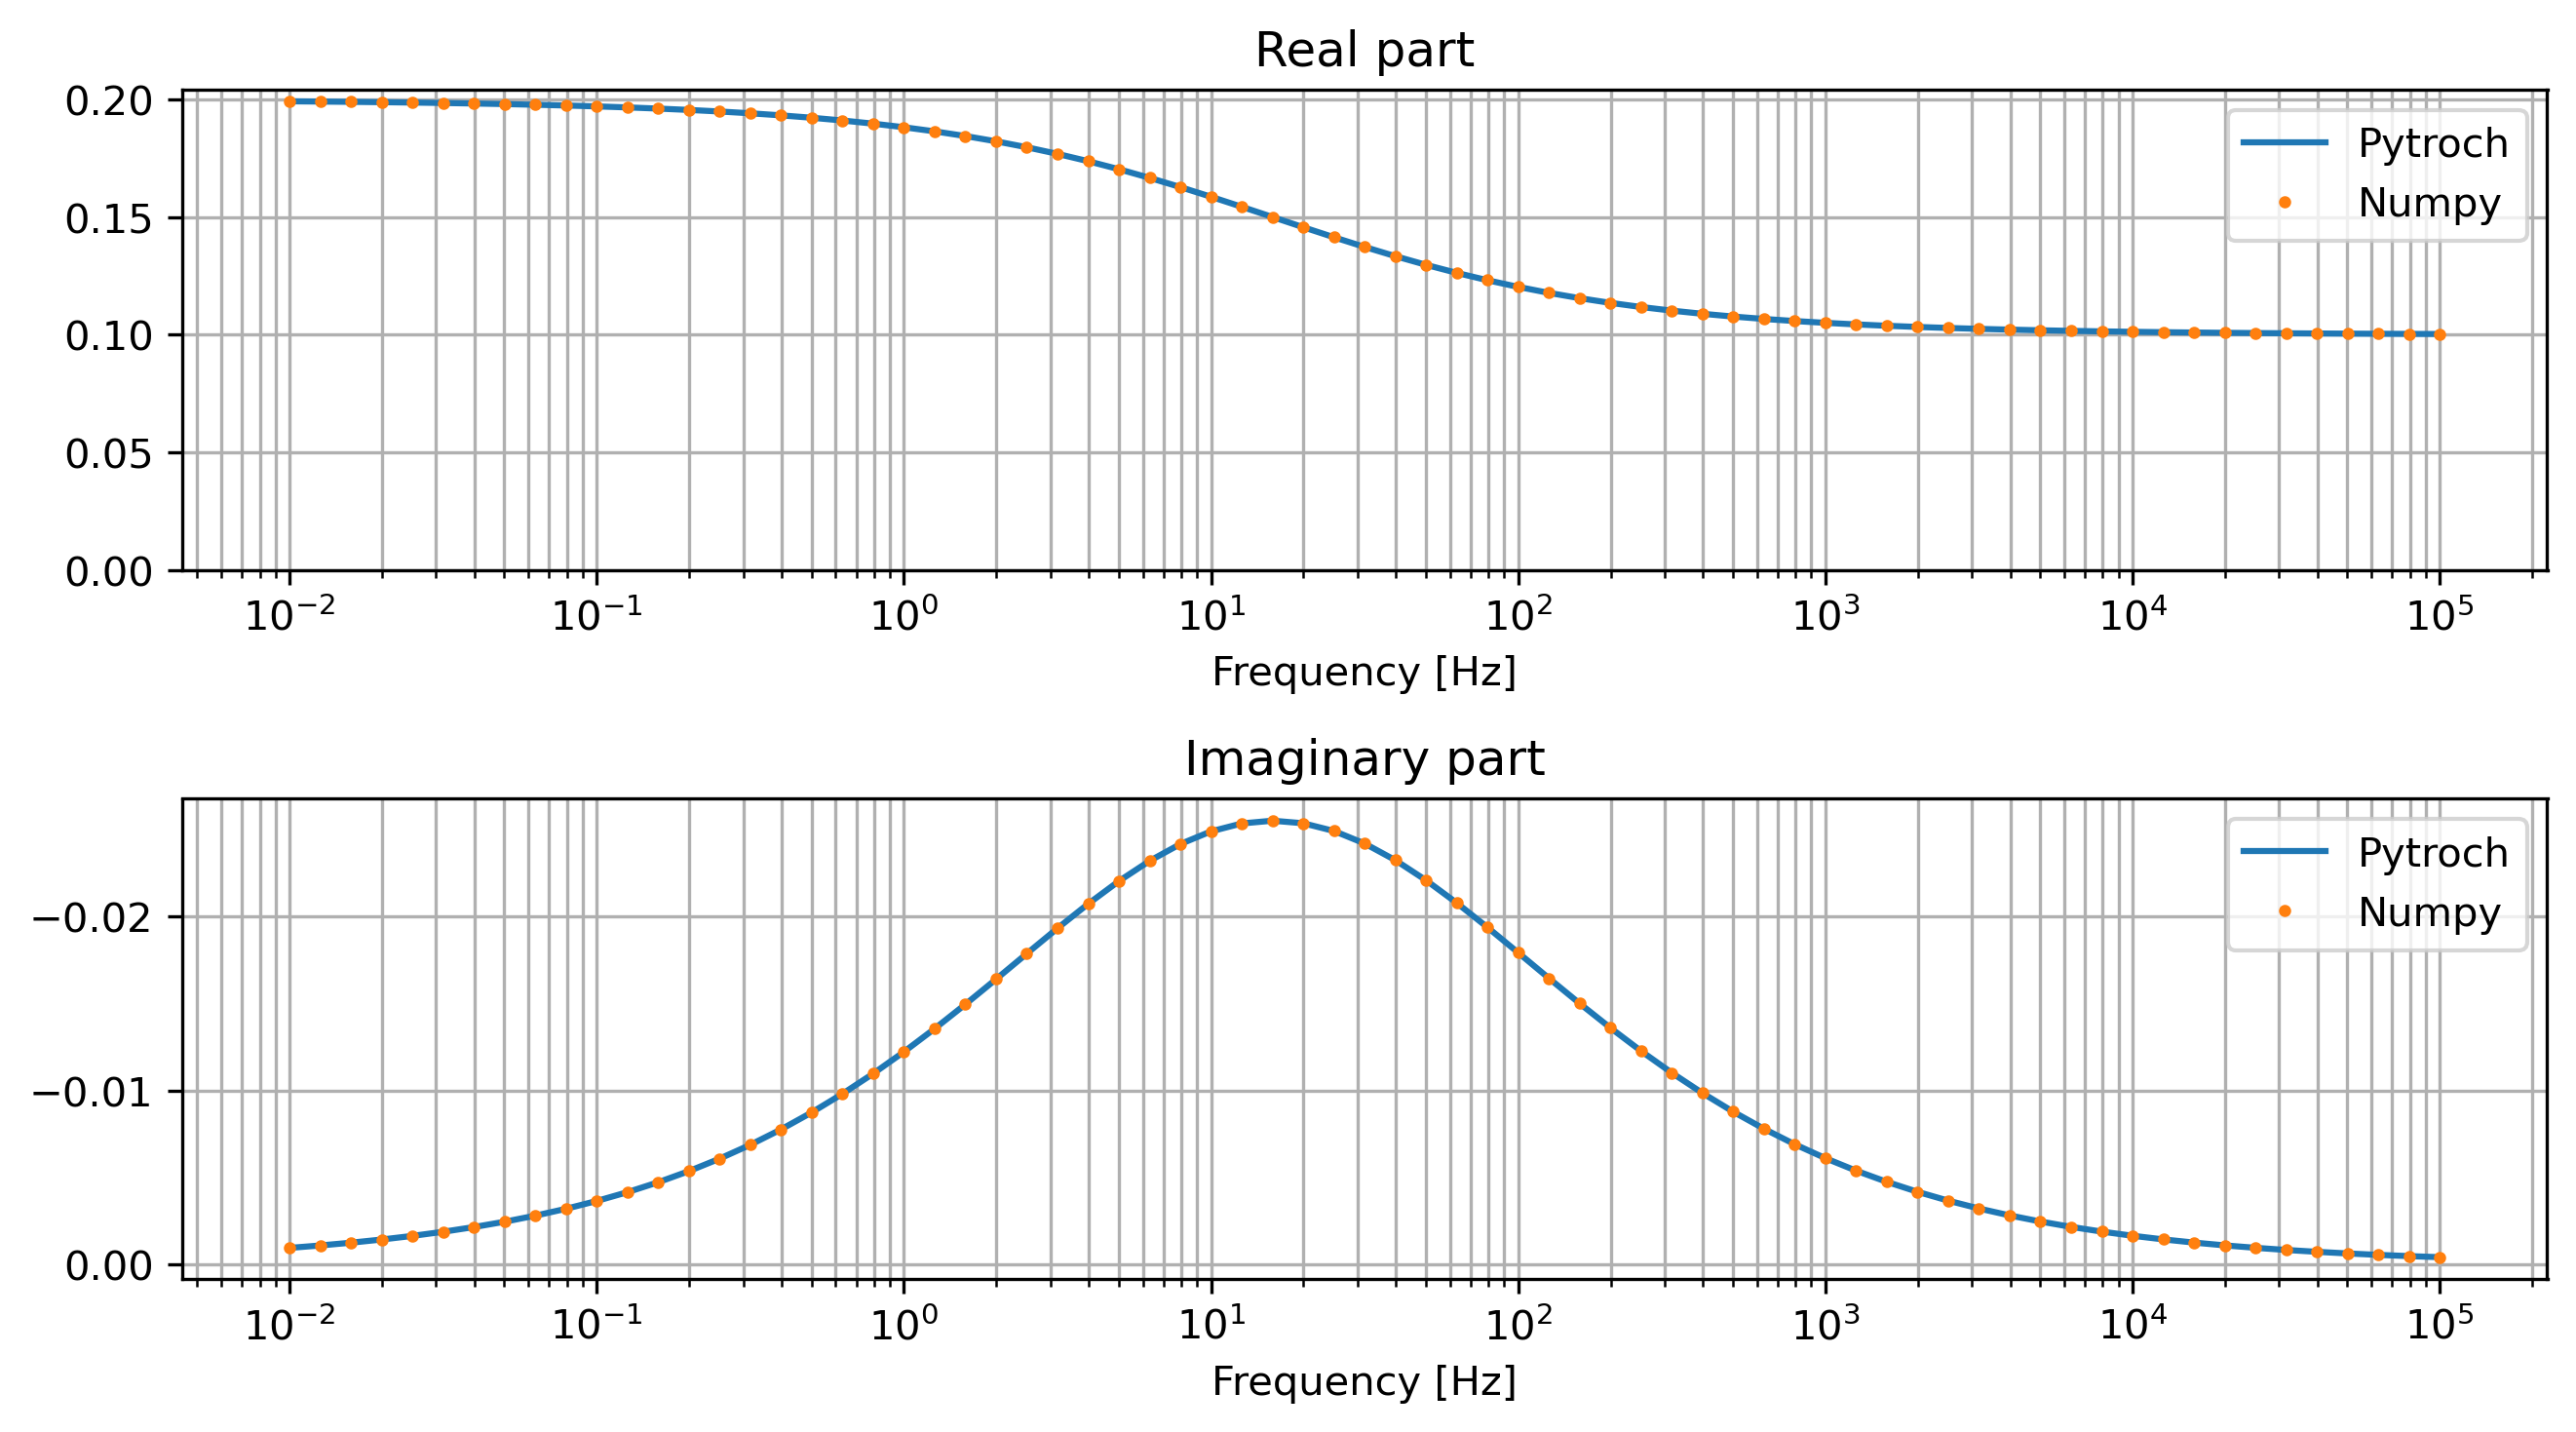

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_torch_real,color = "C0",label="Pytroch")
ax[0].semilogx(freq, dpred_np_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_torch_imag, color = "C0",label="Pytroch")
ax[1].semilogx(freq, dpred_np_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[1].invert_yaxis()

# ax[2].plot(dpred_torch_real, -dpred_torch_imag, color="C0", label="Pytroch")
# ax[2].plot(dpred_np_real, -dpred_np_imag, color="C1",
#               linestyle="",markersize=4.0, marker=".",label="Numpy")
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
# ax[2].set_title("Cole-Cole plot")
# ax[2].set_xlabel("Real")
# ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("13_AuoDiffValid_Pelton_res_sip.jpg", dpi=300)

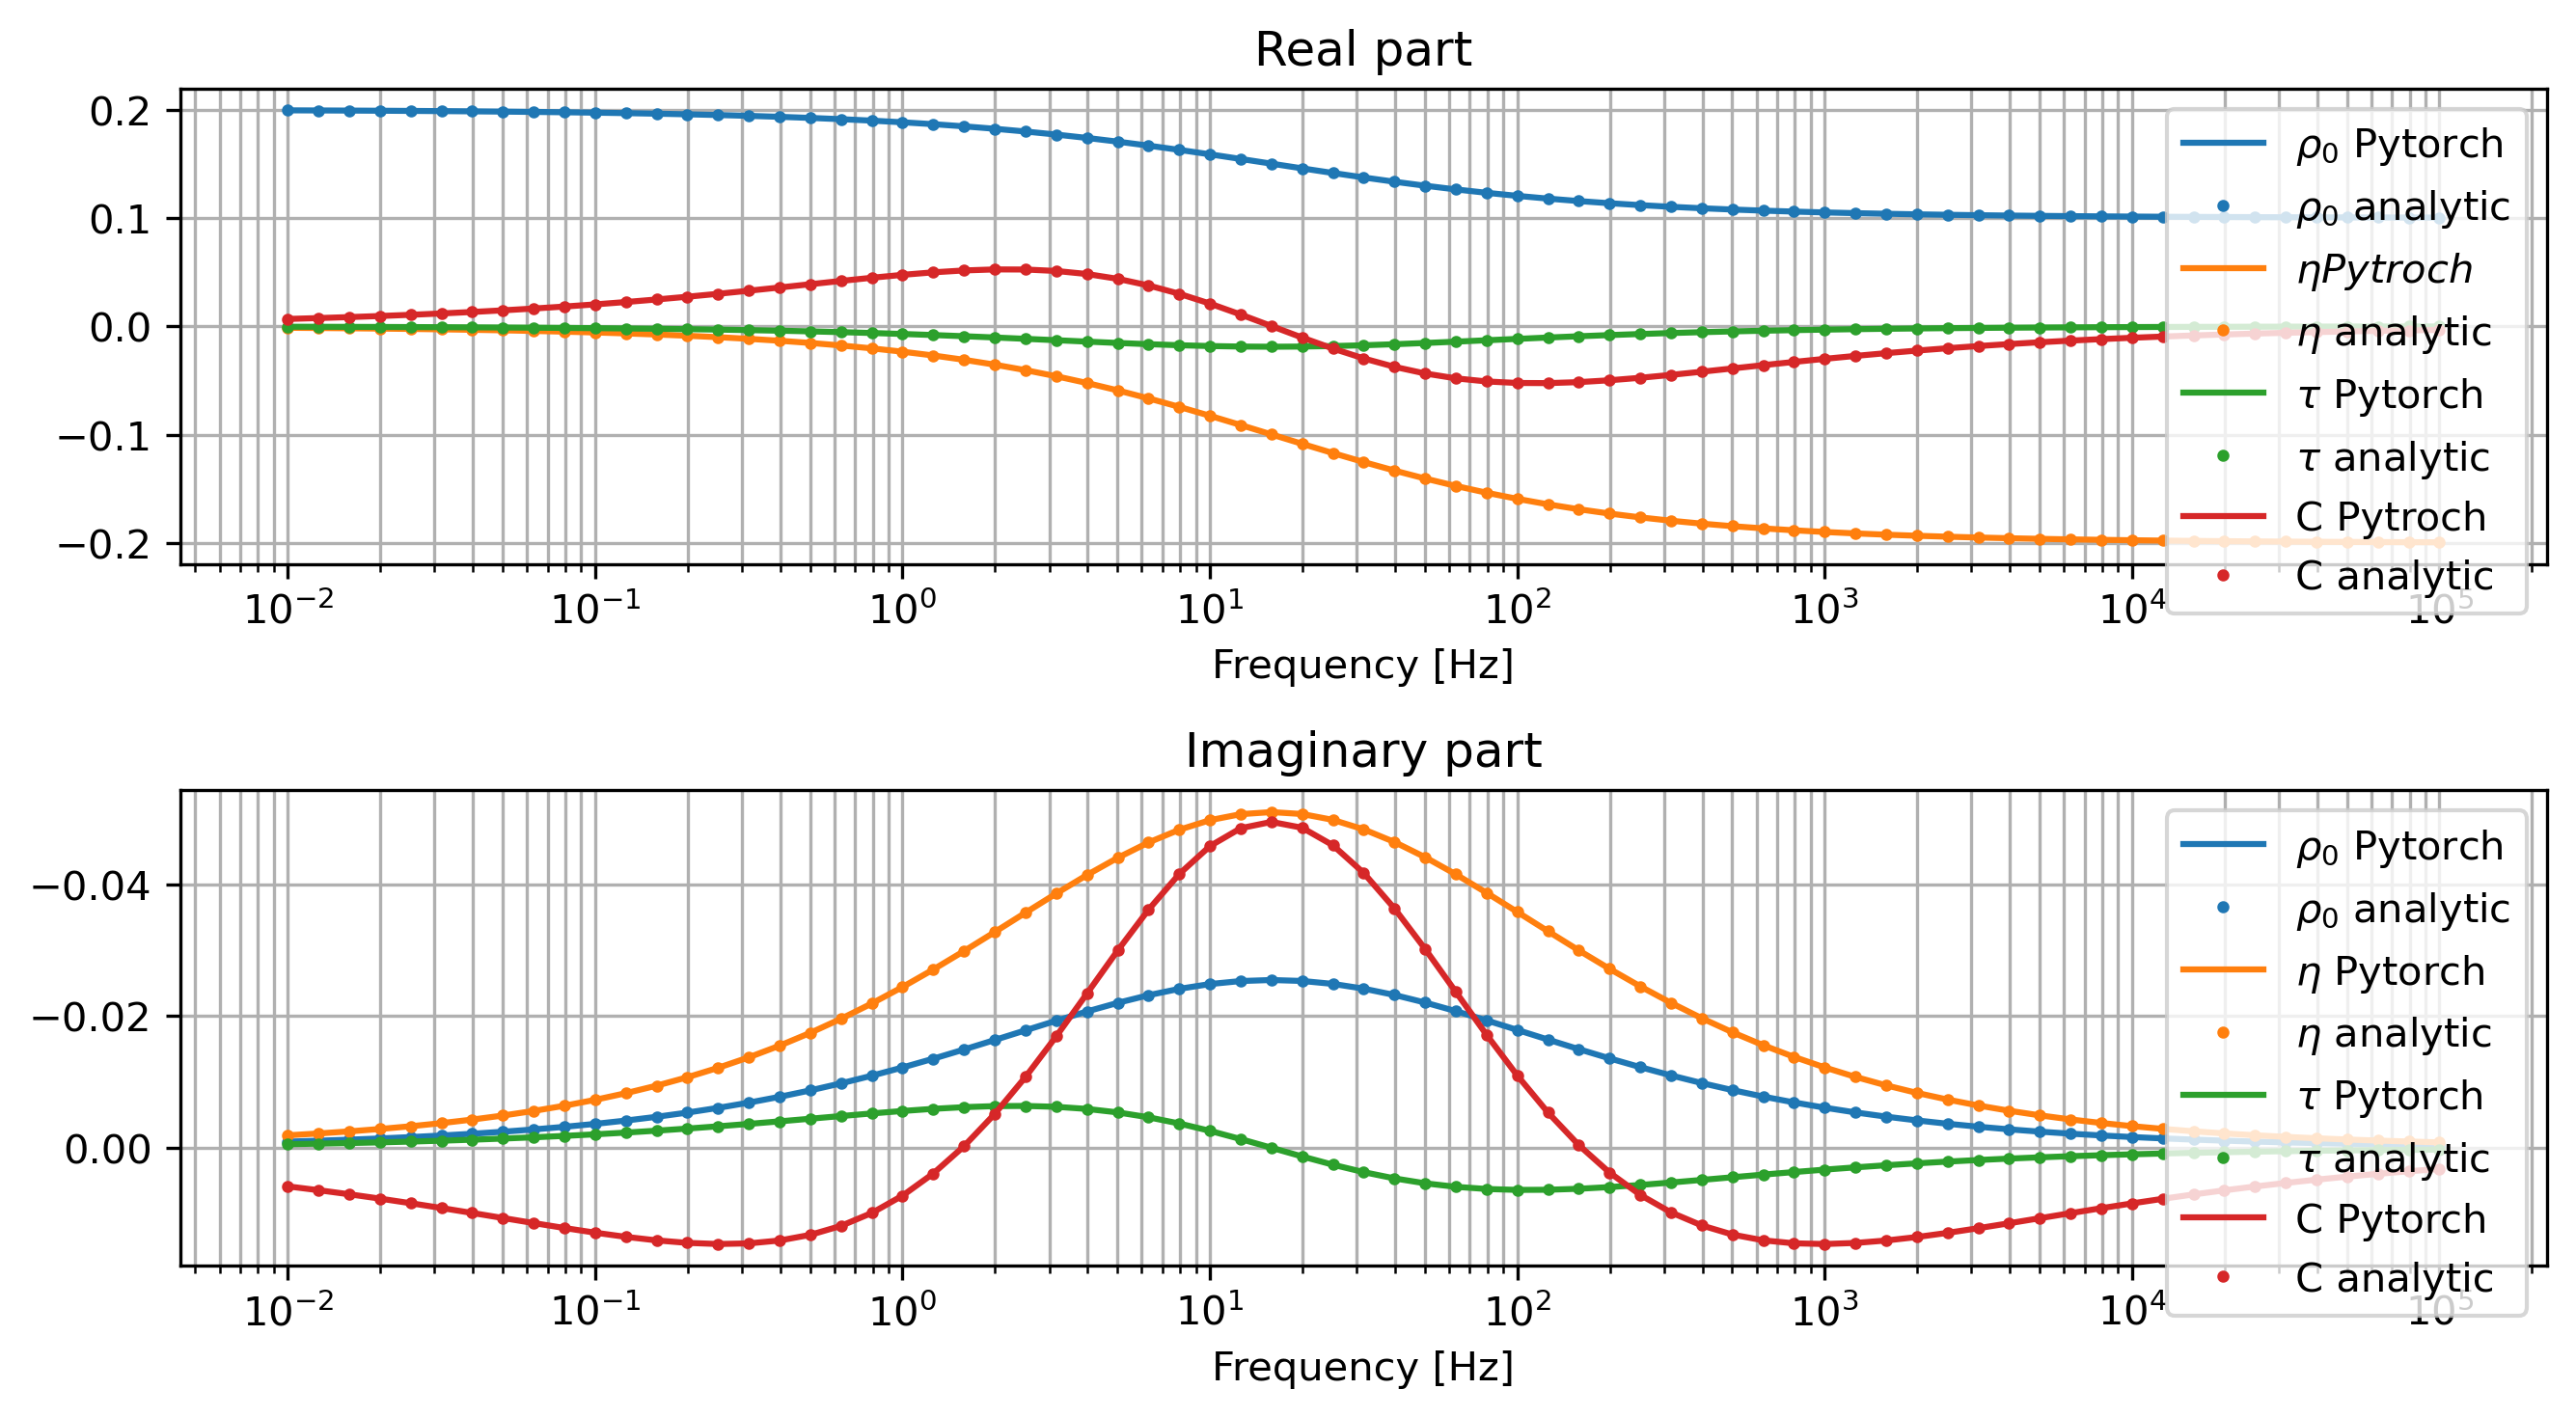

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, J_torch_real[:,0],color = "C0", label=r"$\rho_0$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[0].semilogx(freq, J_torch_real[:,1],color = "C1", label=r"$\eta Pytroch$")
ax[0].semilogx(freq, J_np_real[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[0].semilogx(freq, J_torch_real[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[0].semilogx(freq, J_torch_real[:,3],color = "C3", label="C Pytroch")
ax[0].semilogx(freq, J_np_real[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")

ax[1].semilogx(freq, J_torch_imag[:,0],color = "C0", label=r"$\rho_0$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,1],color = "C1", label=r"$\eta$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,3],color = "C3", label="C Pytorch")
ax[1].semilogx(freq, J_np_imag[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
plt.tight_layout()
plt.savefig("13_AuoDiffValid_Pelton_res_sip_J.jpg", dpi=300)